# Table of Contents
* [THOR dense ds](#THOR-dense-ds)
* [build concordance ds](#build-concordance-ds)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
from tqdm import tqdm as tqdm
from collections import defaultdict
from collections import Counter
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

import os
import cv2
from copy import deepcopy
import PIL.Image as Image
from tqdm import tqdm

import ai2thor.controller
import pickle
import json


controller = ai2thor.controller.Controller()
controller.start()

# THOR dense ds

In [134]:
def get_reachable_pos(scene_id):
    controller.reset(scene_id)
    meta_event = controller.step(dict(action='Initialize', gridSize=0.25))
    meta_event = controller.step(dict(action='GetReachablePositions'))
    return meta_event.metadata['reachablePositions']



def take_image_w_md(event):
    all_md = event.metadata
    relevant_md = {
        'cameraPosition': all_md['cameraPosition'],
        'agentPosition': all_md['agent']['position'],
        'agentRotation': all_md['agent']['rotation']['y'],
    }
    x, z = [round(relevant_md['agentPosition'][co], 2) for co in ['x', 'z']]
    rot = round(relevant_md['agentRotation'], 2)
    img_name = f'img_{x}_{z}_{rot}'.replace('.', 'p') + '.png'
    relevant_md['imageName'] = img_name
    save_image(event, img_name)
    return relevant_md

def inflate_neighborhood(pos):
    meta_event = controller.step(dict(action='Initialize', gridSize=0.05))
    trans_dists = [0.05, -0.05]
    rot_ang = 5
    event = controller.step(action='TeleportFull', x=pos['x'], y=pos['y'], z=pos['z'], rotation=270)
    orig_pos_md = take_image_w_md(event)
    neighbors_md = []
    for co in ['x', 'z']:
        for td in trans_dists:
            trans_pos = deepcopy(pos)
            trans_pos[co] = pos[co] + td
            trans_pos['rotation'] = orig_pos_md['agentRotation']
            trans_md = teleport(trans_pos)
            if not trans_md:
                continue
            neighbors_md.append(take_image_w_md(trans_md))
    for i in range(-5, 5):
        if i == 0:
            continue
        trans_pos = deepcopy(pos)
        trans_pos['rotation'] = orig_pos_md['agentRotation'] + i * rot_ang
        trans_md = teleport(trans_pos)
        if not trans_md:
            continue
        neighbors_md.append(take_image_w_md(trans_md))
    return orig_pos_md, neighbors_md

def teleport(pos):
    rot = pos.get('rotation', 0)
    new_pos = controller.step(action='TeleportFull', x=pos['x'], y=pos['y'], z=pos['z'], rotation=rot)
    if not new_pos.metadata['lastActionSuccess']:
        print(new_pos.metadata['errorMessage'])
        return False
    return new_pos


def save_image(event, img_name, img_path='concord_ds'):
    img_arr = event.cv2img
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img_arr)
    img.save(os.path.join(img_path, img_name))

    
def build_img_neigh_ds(all_pos):
    sim_img_neigborhood = []
#     for pos in all_pos[:3]:
    for pos in tqdm(all_pos):
        orig_md, neigh_md = inflate_neighborhood(pos)
        sim_img_neigborhood.append({'grid_loc': orig_md, 'neighbors': neigh_md})
    return sim_img_neigborhood

In [119]:
range(-5, 5)

range(-5, 5)

In [68]:
scene_id = 'FloorPlan_RVal2_2'
all_orig_pos = get_reachable_pos(scene_id)

In [69]:
all_orig_pos

[{'x': 5.25, 'y': 0.900999248, 'z': -1.5},
 {'x': 5.5, 'y': 0.900999248, 'z': -1.5},
 {'x': 5.25, 'y': 0.900999248, 'z': -1.25},
 {'x': 5.0, 'y': 0.900999248, 'z': -1.5},
 {'x': 5.75, 'y': 0.900999248, 'z': -1.5},
 {'x': 5.5, 'y': 0.900999248, 'z': -1.25},
 {'x': 5.5, 'y': 0.900999248, 'z': -1.75},
 {'x': 5.0, 'y': 0.900999248, 'z': -1.25},
 {'x': 4.75, 'y': 0.900999248, 'z': -1.5},
 {'x': 6.0, 'y': 0.900999248, 'z': -1.5},
 {'x': 5.75, 'y': 0.900999248, 'z': -1.25},
 {'x': 5.75, 'y': 0.900999248, 'z': -1.75},
 {'x': 5.5, 'y': 0.900999248, 'z': -2.0},
 {'x': 4.75, 'y': 0.900999248, 'z': -1.25},
 {'x': 4.5, 'y': 0.900999248, 'z': -1.5},
 {'x': 6.25, 'y': 0.900999248, 'z': -1.5},
 {'x': 6.0, 'y': 0.900999248, 'z': -1.25},
 {'x': 6.0, 'y': 0.900999248, 'z': -1.75},
 {'x': 5.5, 'y': 0.900999248, 'z': -2.25},
 {'x': 4.5, 'y': 0.900999248, 'z': -1.25},
 {'x': 4.25, 'y': 0.900999248, 'z': -1.5},
 {'x': 6.5, 'y': 0.900999248, 'z': -1.5},
 {'x': 6.25, 'y': 0.900999248, 'z': -1.25},
 {'x': 6.25,

In [23]:
neigh_ds = build_img_neigh_ds(all_orig_pos)

100%|██████████| 261/261 [05:55<00:00,  1.29s/it]


In [24]:
with open('val_2_2_neigborhood_ds.json', 'w') as f:
    json.dump(neigh_ds, f, indent=3, sort_keys=True)

In [170]:
# build_img_neigh_ds(all_orig_pos)

In [171]:
tt1 = inflate_neighborhood(all_orig_pos[-4])

{'x': 2.3, 'y': 0.900999248, 'z': -2.75, 'rotation': 269.999542}
True
{'x': 2.25, 'y': 0.900999248, 'z': -2.75}
{'x': 2.2, 'y': 0.900999248, 'z': -2.75, 'rotation': 269.999542}
True
{'x': 2.25, 'y': 0.900999248, 'z': -2.75}
{'x': 2.25, 'y': 0.900999248, 'z': -2.7, 'rotation': 269.999542}
True
{'x': 2.25, 'y': 0.900999248, 'z': -2.75}
{'x': 2.25, 'y': 0.900999248, 'z': -2.8, 'rotation': 269.999542}
True
{'x': 2.25, 'y': 0.900999248, 'z': -2.75}


In [55]:
tp = all_orig_pos[0]

In [121]:
# ttmd = controller.step(action='TeleportFull', x=tp['x'] + 2, y=tp['y'], z=tp['z'], rotation=269.999542)

In [63]:
ttmd.metadata['agent']['position']

{'x': 7.25, 'y': 0.900999248, 'z': -1.5}

In [64]:
ttmd.metadata['lastActionSuccess']

True

In [65]:
ttmd.metadata.keys()

dict_keys(['objects', 'isSceneAtRest', 'agent', 'hand', 'fov', 'isStanding', 'cameraPosition', 'cameraOrthSize', 'thirdPartyCameras', 'collided', 'collidedObjects', 'inventoryObjects', 'sceneName', 'lastAction', 'errorMessage', 'errorCode', 'lastActionSuccess', 'screenWidth', 'screenHeight', 'agentId', 'colors', 'colorBounds', 'reachablePositions', 'flatSurfacesOnGrid', 'distances', 'normals', 'isOpenableGrid', 'segmentedObjectIds', 'objectIdsInBox', 'actionIntReturn', 'actionFloatReturn', 'actionStringsReturn', 'actionFloatsReturn', 'actionVector3sReturn', 'visibleRange', 'actionReturn', 'currentTime'])

In [66]:
ttmd.metadata['agent']['position']

{'x': 7.25, 'y': 0.900999248, 'z': -1.5}

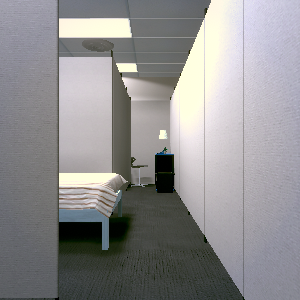

In [67]:
Image.fromarray(ttmd.cv2img)

In [14]:
ti1 = all_orig_pos.cv2image()

In [131]:
# Image.fromarray(ttmd.cv2image)

# build concordance ds

In [158]:
def real2sim_pos(real_pos):
    real_vec = np.array([[real_pos['x']],
                         [real_pos['z']],
                         [1]])

    # affine matrix transformer
#     A = np.array([[ 0.94237916,  0.0165435 ,  0.85515405],
#                   [-0.01759903,  0.91987387, -1.1198701 ]])
    
    A = np.array([[ 1.00854301, -0.0111386 ,  0.51920809],
                   [ 0.00316833,  0.97336625, -1.15532594]])

    s = np.dot(A, real_vec).reshape(-1)
    real_pos['x'] = s[0]
    real_pos['z'] = s[1]
    return real_pos

def get_sim_coords(real_md):
    real_pos = {**real_md['agent']['position'], 'rotation': real_md['agent']['rotation']}
    real_pos['z'] = real_pos['y']
    real_pos['y'] = 0.83
    sim_corr = real2sim_pos(real_pos)
    return sim_corr

def load_real_img(img_n):
    img_path = f'{base_dir}/images/{img_n}.jpg'
    img = Image.open(img_path)
    return img


def get_thor_img_at_real_loc(scene_id, real_md):
    sim_corr = get_sim_coords(real_md)
    print(sim_corr)
    controller.reset(scene_id)
    meta_event = controller.step(dict(action='Initialize', gridSize=0.05))
    sim_pos = teleport(sim_corr)
    img_arr = sim_pos.cv2img
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img_arr)
    return img, sim_pos.metadata

In [121]:
scene_id = 'FloorPlan_RVal2_2'

In [160]:
base_dir = '/Users/schwenk/wrk/transfer/updated_metadata_collection/'

with open (base_dir + 'metadata.pickle', 'rb') as f:
    real_md = pickle.load(f)

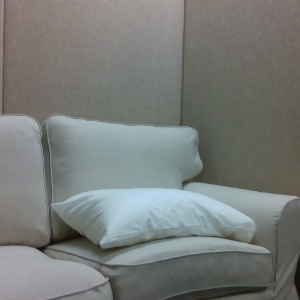

In [166]:
img_n, real_img_md = list(real_md.items())[5]
load_real_img(img_n)

In [162]:
get_sim_coords(real_img_md)

{'y': 0.83,
 'x': 6.562386812299999,
 'rotation': 110.76999722502785,
 'z': -3.07438321365}

In [163]:
all_real_pos = [get_sim_coords(im) for im in real_md.values()]

In [138]:
neigh_ds = build_img_neigh_ds(all_real_pos)

100%|██████████| 66/66 [01:33<00:00,  1.17s/it]


In [153]:
real_ds = []
for img_n, md in real_md.items():
    dp = {
        'imageName': f'{img_n}.jpg',
        **md['agent']
    }
    dp['position'] = get_sim_coords(md)
    real_ds.append(dp)

In [157]:
with open('val_2_2_real_concord_ds.json', 'w') as f:
    json.dump(real_ds, f, indent=3, sort_keys=True)

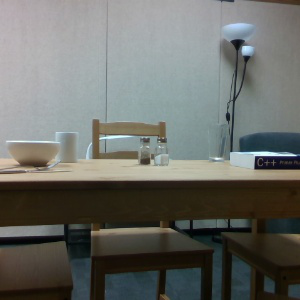

In [181]:
img_n, real_img_md = list(real_md.items())[-20]
load_real_img(img_n)

{'y': 0.83, 'x': 7.377735180869999, 'rotation': 11.410004935574563, 'z': -4.08026548964}


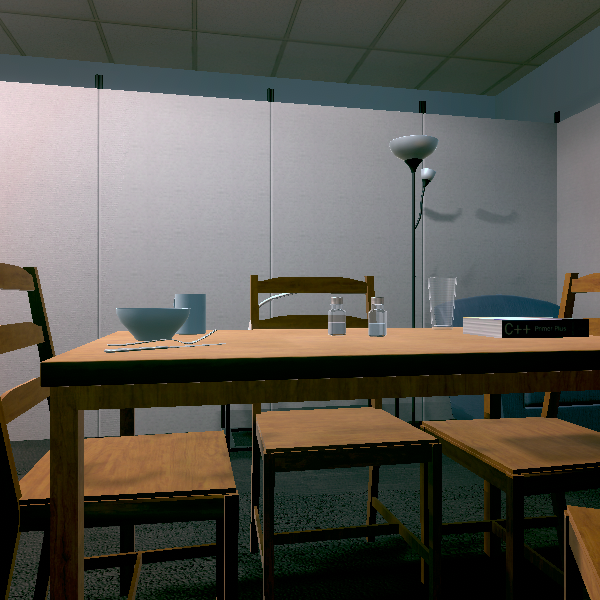

In [182]:
trp1, debug_simp = get_thor_img_at_real_loc(scene_id, real_img_md)
trp1